# Machine Learning Essentials - Summer Semester 2024 // Exercise 06

## Team-Member
### 1. Sushmitha Chandrakumar - 4732591
### 2. Aarohi Verma - 4742978
### 3. Colin Fredynand - 4730221

## Task 1

# Import Libraries

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from collections import Counter
from abc import ABC, abstractmethod

# Base Classes

In [2]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally:
          prediction
    '''
    pass

class Tree(ABC):
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min

    def predict(self, X):
        ''' return the predictions for the given feature matrix X
        '''
        if X.ndim == 1:
            return self._predict_one(X)
        else:
            return np.array([self._predict_one(x) for x in X])

    def _predict_one(self, x):
        ''' return the prediction for a single 1-D feature vector x
        '''
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.prediction

    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision

        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)

    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature
                         indices to be considered for the present split

        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None

        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        node.split_index = j_min
        node.threshold = t_min
        node.left = left
        node.right = right

        # return the children (to be placed on the stack)
        return left, right

    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.choice(D, D_try, replace=False)

    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        feature_values = node.features[:, j]
        unique_values = np.unique(feature_values)
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2
        return thresholds

    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t

            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()

        mask_left = node.features[:, j] <= t
        mask_right = ~mask_left

        left.features = node.features[mask_left]
        left.responses = node.responses[mask_left]

        right.features = node.features[mask_right]
        right.responses = node.responses[mask_right]

        return left, right

    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`

            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")

    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').

            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree

In [3]:
class RegressionTree(Tree, BaseEstimator, RegressorMixin):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)

    def compute_loss_for_split(self, node, j, t):
        mask_left = node.features[:, j] <= t
        mask_right = ~mask_left

        if np.sum(mask_left) < self.n_min or np.sum(mask_right) < self.n_min:
            return float('inf')

        left_responses = node.responses[mask_left]
        right_responses = node.responses[mask_right]

        loss_left = np.var(left_responses) * len(left_responses)
        loss_right = np.var(right_responses) * len(right_responses)

        return loss_left + loss_right

    def make_leaf_node(self, node):
        node.prediction = np.mean(node.responses)

    def fit(self, X, y):
        self.train(X, y)
        return self

# Classification Tree

In [4]:
class ClassificationTree(Tree, BaseEstimator, ClassifierMixin):
    '''implement classification tree so that it can handle arbitrary many classes
    '''

    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes

    def compute_loss_for_split(self, node, j, t):
        mask_left = node.features[:, j] <= t
        mask_right = ~mask_left

        if np.sum(mask_left) < self.n_min or np.sum(mask_right) < self.n_min:
            return float('inf')

        left_responses = node.responses[mask_left]
        right_responses = node.responses[mask_right]

        loss_left = self.gini_impurity(left_responses) * len(left_responses)
        loss_right = self.gini_impurity(right_responses) * len(right_responses)

        return loss_left + loss_right

    def gini_impurity(self, responses):
        counts = np.array(list(Counter(responses).values()))
        probabilities = counts / len(responses)
        return 1.0 - np.sum(probabilities ** 2)

    def make_leaf_node(self, node):
        counts = Counter(node.responses)
        node.prediction = max(counts, key=counts.get)

    def fit(self, X, y):
        self.train(X, y)
        self.classes_ = np.unique(y)
        return self

# Evaluation of Regression and Classification Tree

In [5]:
# Load and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# For regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

# Perform 5-fold cross-validation with responses +1 and -1 (for 3s and 9s) using RegressionTree()
regression_tree = RegressionTree(n_min=2)
kf = KFold(n_splits=5, shuffle=True, random_state=1)

regression_scores = cross_val_score(regression_tree, features, responses, cv=kf, scoring='neg_mean_squared_error')
print(f"RegressionTree MSE: {-np.mean(regression_scores)}")

# Perform 5-fold cross-validation with labels 3 and 9 using ClassificationTree
classification_tree = ClassificationTree(classes=np.unique(labels), n_min=2)
classification_scores = cross_val_score(classification_tree, features, labels, cv=kf, scoring='accuracy')
print(f"ClassificationTree Accuracy: {np.mean(classification_scores)}")

(1797, 64) (1797,)
RegressionTree MSE: 0.3626839167935058
ClassificationTree Accuracy: 0.903386605783866


## Task 2

# Regression and Classification Forest

In [6]:
def bootstrap_sampling(X, y):
    n_samples = X.shape[0]
    indices = np.random.choice(n_samples, size=n_samples, replace=True)
    return X[indices], y[indices]

In [7]:
class RegressionForest(BaseEstimator, RegressorMixin):
    def __init__(self, n_trees=100):
        self.n_trees = n_trees
        self.trees = [RegressionTree() for _ in range(n_trees)]

    def fit(self, X, y):
        for tree in self.trees:
            X_sample, y_sample = bootstrap_sampling(X, y)
            tree.fit(X_sample, y_sample)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

    def get_params(self, deep=True):
        return {"n_trees": self.n_trees}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [8]:
class ClassificationForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=100, classes=None):
        self.n_trees = n_trees
        self.classes = classes
        self.trees = [ClassificationTree(classes=classes) for _ in range(n_trees)]

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for tree in self.trees:
            X_sample, y_sample = bootstrap_sampling(X, y)
            tree.fit(X_sample, y_sample)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x, minlength=len(self.classes)).argmax(), axis=0, arr=predictions)

    def get_params(self, deep=True):
        return {"n_trees": self.n_trees, "classes": self.classes}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

#Task 3

In [9]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Cross-validated accuracies: [0.96111111 0.95833333 0.93314763 0.9637883  0.95543175]
Mean accuracy: 0.9543624264933458


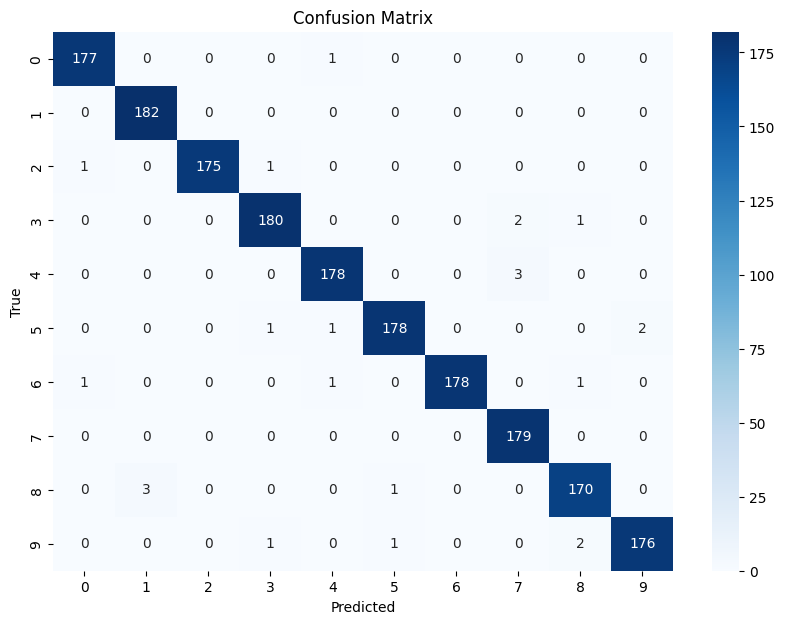

In [11]:
# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Get the unique classes of y
classes = np.unique(y)

# Initialize the forest
classification_forest = ClassificationForest(n_trees=100, classes=classes)

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = cross_val_score(classification_forest, X, y, cv=kf, scoring='accuracy')

print(f'Cross-validated accuracies: {accuracies}')
print(f'Mean accuracy: {np.mean(accuracies)}')

# Fit and predict for the confusion matrix
classification_forest.fit(X, y)
y_pred = classification_forest.predict(X)

# Plot the confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## **Comments :**
The confusion matrix will show how well the model distinguishes between different digits.
Accuracy should be high, typically above 80%, reflecting the robustness of the forest model in multi-class classification.

# Task 4

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin

class RegressionForestOneVsRest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_trees=100):
        self.n_trees = n_trees
        self.models = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        for cls in self.classes_:
            y_binary = np.where(y == cls, 1, 0)
            model = RandomForestRegressor(n_estimators=self.n_trees)
            model.fit(X, y_binary)
            self.models[cls] = model
        return self

    def predict(self, X):
        scores = {cls: model.predict(X) for cls, model in self.models.items()}
        scores_matrix = np.vstack(list(scores.values())).T
        max_scores = scores_matrix.max(axis=1)
        max_indices = scores_matrix.argmax(axis=1)
        y_pred = np.where(max_scores > 0, self.classes_[max_indices], -1)  # -1 indicates 'unknown'
        return y_pred

    def get_params(self, deep=True):
        return {"n_trees": self.n_trees}

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self


Cross-validated accuracies: [0.95833333 0.95833333 0.9275766  0.9637883  0.95264624]
Mean accuracy: 0.9521355617455896


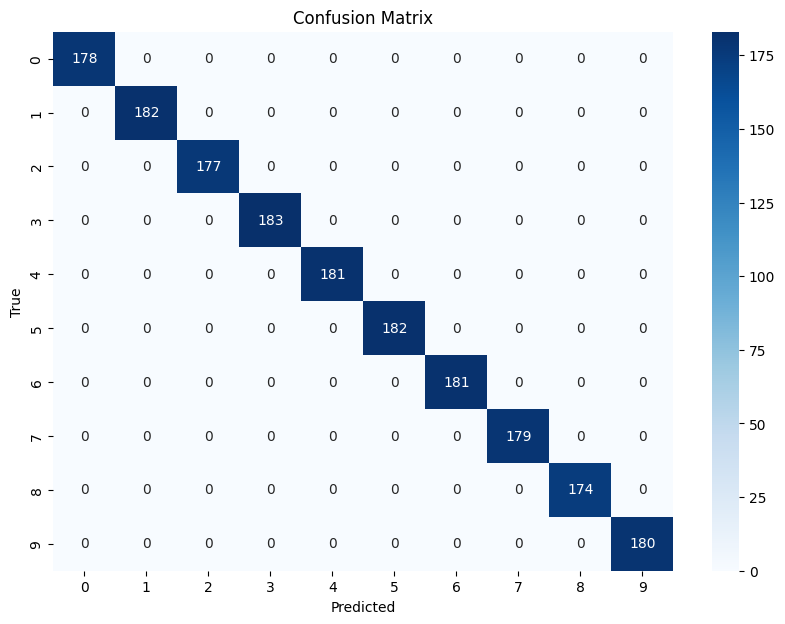

In [15]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the digits dataset
digits = load_digits()
X = digits.data
y = digits.target

# Initialize the one-vs-rest regression forest
regression_forest = RegressionForestOneVsRest(n_trees=100)

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = cross_val_score(regression_forest, X, y, cv=kf, scoring='accuracy')

print(f'Cross-validated accuracies: {accuracies}')
print(f'Mean accuracy: {np.mean(accuracies)}')

# Fit and predict for the confusion matrix
regression_forest.fit(X, y)
y_pred = regression_forest.predict(X)

# Plot the confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## **Comments :**
The confusion matrix will highlight the performance of the one-against-the-rest approach for multi-class classification.
Accuracy should be comparable to that of the classification forest, showing the effectiveness of using regression forests in this setting.